# Chapter 10
###### Brian Stampe

In [51]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [179]:
# 10.E

def log_odds(p):
    return np.log(p/(1-p))

log_odds(.35)

(-0.6190392084062235, 0.5866175789173301)

In [180]:
def p_from_log_odds(logodds):
    return np.exp(logodds)/(1+np.exp(logodds))

p_from_log_odds(3.2), logistic(3.2)

(0.9608342772032357, 0.9608342772032357)

In [20]:
np.exp(1.7)

5.4739473917272

10.E.3 The coefficient is interpretated as having a 5.5 times as effect on the log odds of the outcome.


10.E.4 Offsets are used to account for counts over different time scales. that way you can account realistically for rate by allowing the offset to account for the varying exposures of each instance. 


M.1 Intuitively because it may be fairly likely to get 1/1 but very difficult to get 1000/1000, even though they have the same ratio. 


M.2 

The expected value or rate of the outcome process is e^1.7 or 5.5 times as fast for an increase of one unit of explainitary variable. 

M.3 The logist link forces the outcome variable to be between 0-1, which is necessary to model a Probability parameter in the binomial function. Other links could force this relationship as well. 

M.4 The log link forces the outcome variable to be positive. And does not constrain i.e. 0-infinity. Rates are always positive I guess.

M.5  It would force the rate variable between 0-1. 

M.6  The exponential distribution arises from measures of distance or duration between events. If the p of an event is constant across time/space, then the distribution distance/time between events tends toward exponential. If we count these events, the distribution becomes discrete and binomial. For a count outcome y for which each observation arises from n trials and with constant expected value np, the binomial distribution has maximum entropy. The poisson is just a special case of the binomial whereby there is a very small p and very large n, such that gamma = np. Under these conditions the binomail converges to a Poisson, it is convenient since it only has one parameter. 





In [185]:
# eagles H.3
# can't find df

In [50]:
d = pd.read_csv('Data/NWO.csv')
d

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18
5,Physics,f,9,2
6,Humanities,m,230,33
7,Humanities,f,166,32
8,Technical sciences,m,189,30
9,Technical sciences,f,62,13


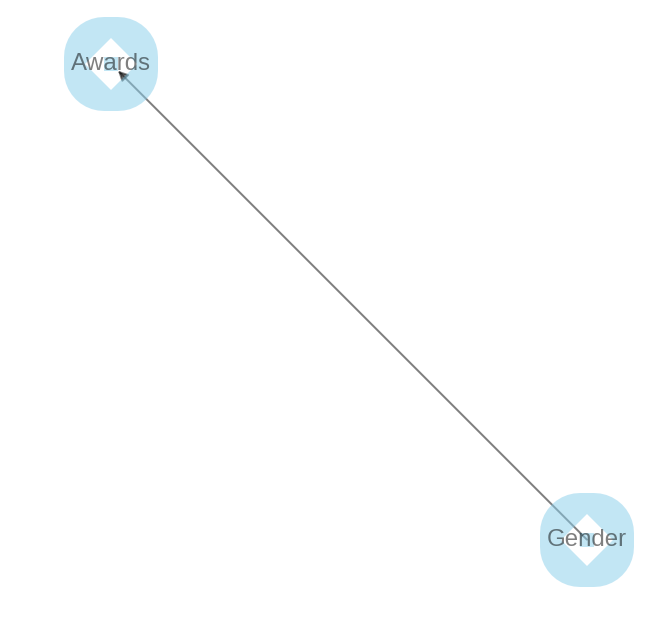

In [62]:
# DAG

plt.figure(figsize=(4,4))
G = nx.DiGraph()
rvs = ['Gender', 'Awards']

G.add_nodes_from(rvs)
G.add_edges_from([('Gender','Awards')], weight=1)
#nx.draw_networkx(G, arrows=True)
nx.draw(G, with_labels=True, node_size=50, node_color="skyblue", fontsize = 100, fontweight = 'bold',node_shape="s", alpha=0.5, linewidths=40)
plt.show()

In [59]:
d['male'] = (d.gender == 'm').astype(int)
d

,discipline,gender,applications,awards,male
0,Chemical sciences,m,83,22,1
1,Chemical sciences,f,39,10,0
2,Physical sciences,m,135,26,1
3,Physical sciences,f,39,9,0
4,Physics,m,67,18,1
5,Physics,f,9,2,0
6,Humanities,m,230,33,1
7,Humanities,f,166,32,0
8,Technical sciences,m,189,30,1
9,Technical sciences,f,62,13,0


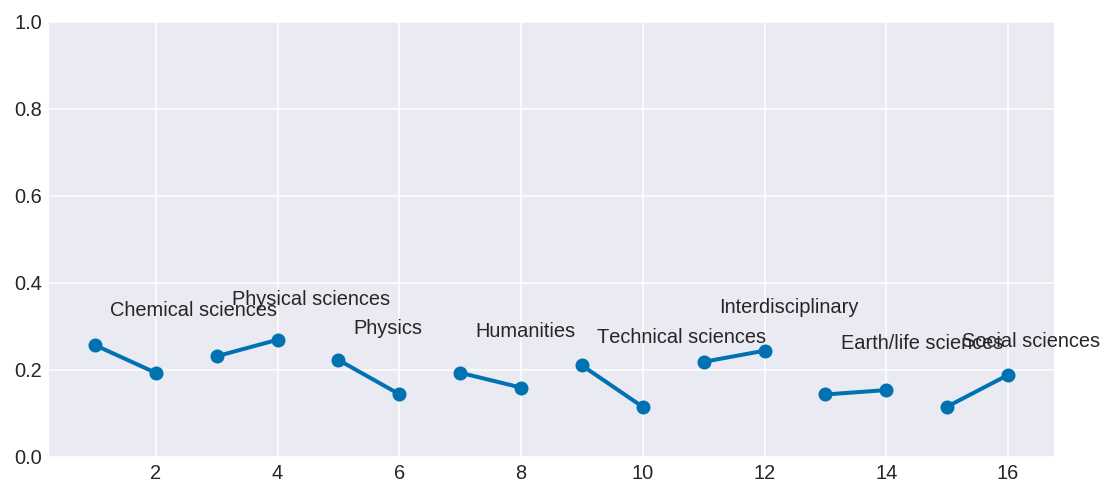

In [101]:
plt.figure(figsize=(9,4))
for i in range(8):
    x = 1 + 2 * i
    y1 = d.awards[x] / d.applications[x]
    y2 = d.awards[x+1] / d.applications[x+1]
    plt.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    plt.text(x + 0.25, (y1+y2)/2 + 0.1, d.discipline[x])
plt.ylim(0, 1);

In [186]:
# What are the average probabilities of admission for females and males, across all departments?

with pm.Model() as model_10_1:
    a = pm.Normal('a', -1, 1)
    bm = pm.Normal('bm', 0, 1)
    p = pm.math.invlogit(a + bm * d.male)
    awards = pm.Binomial('awards', p=p, n=d.applications, observed=d.awards)
    
    trace_10_1 = pm.sample(1000, tune=1000)
    
with pm.Model() as model_10_2:
    a = pm.Normal('a', 0, 10)
    p = pm.math.invlogit(a)
    awards = pm.Binomial('awards', p=p, n=d.applications, observed=d.awards)
    
    trace_10_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bm, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4509.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:01<00:00, 4840.31draws/s]


In [187]:
pm.summary(trace_10_1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-1.734132,0.078928,0.002234,-1.884607,-1.581867,1185.455236,0.999993
bm,0.195517,0.100035,0.002856,0.005543,0.391001,1166.596779,0.999900


In [188]:
# e^bm

print ('By being male the odds of being funded go up by a factor of \n', 
       np.round(np.exp(trace_10_1.bm.mean()),2))
# keep in mind previous DAG
# also keep in mind relative vs. absolute scales

By being male the odds of being funded go up by a factor of 
 1.22


In [64]:
comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2}, method = 'pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2'])
comp_df = comp_df.set_index('model')
comp_df

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.1,129.38,4.54,0,0.62,8.6,0,1
m10.2,130.36,2.83,0.98,0.38,12.92,6.55,1


This suggest not a lot of predictive accuracy gained from including maleness in admissions model. 



In [181]:
post = pm.trace_to_dataframe(trace_10_1)
p_admit_male = p_from_log_odds(post['a'] + post['bm'])
p_admit_female = p_from_log_odds(post['a'])
diff_admit = p_admit_male - p_admit_female
diff_admit.describe(percentiles=[.025, .5, .975])[['2.5%', '50%', '97.5%']]

2.5%     0.002278
50%      0.028753
97.5%    0.055511
dtype: float64

The absolute scale above. The difference in probability you gain by being male in the absolute scale. 3%.


Lets look for a more nuanced view. What else could help predict and even explain (gasp)  acceptance rates????

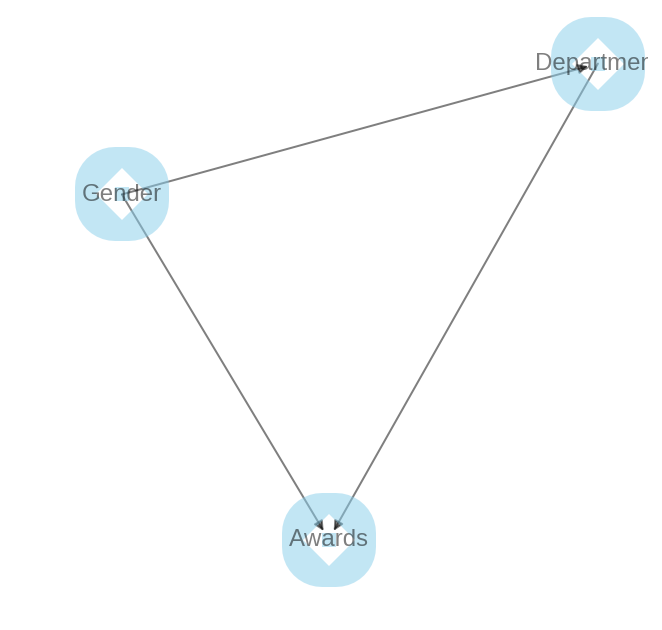

In [61]:
######
# DAG
######

plt.figure(figsize=(4,4))
G = nx.DiGraph()
rvs = ['Gender', 'Department','Awards']

G.add_nodes_from(rvs)
G.add_edges_from([('Gender','Department'),('Department','Awards'),('Gender','Awards')], weight=1)
#nx.draw_networkx(G, arrows=True)
nx.draw(G, with_labels=True, node_size=50, node_color="skyblue", fontsize = 100, fontweight = 'bold',node_shape="s", alpha=0.5, linewidths=40)
plt.show()

In [103]:
d['discipline_id'] = pd.Categorical(d['discipline']).codes
d

,discipline,gender,applications,awards,male,discipline_id
0,Chemical sciences,m,83,22,1,0
1,Chemical sciences,f,39,10,0,0
2,Physical sciences,m,135,26,1,5
3,Physical sciences,f,39,9,0,5
4,Physics,m,67,18,1,6
5,Physics,f,9,2,0,6
6,Humanities,m,230,33,1,2
7,Humanities,f,166,32,0,2
8,Technical sciences,m,189,30,1,8
9,Technical sciences,f,62,13,0,8


In [108]:
with pm.Model() as model_10_3:
    a = pm.Normal('a', 0, 1, shape=len(d['discipline'].unique()))
    p = pm.math.invlogit(a[d['discipline_id'].values])
    awards = pm.Binomial('awards', p=p, n=d['applications'], observed=d['awards'])
    
    trace_10_3 = pm.sample(1000, tune=1000)

with pm.Model() as model_10_4:
    a = pm.Normal('a', 0, 1, shape=len(d['discipline_id'].unique()))
    bm = pm.Normal('bm', 0, 1)
    p = pm.math.invlogit(a[d['discipline_id'].values] + bm * d['male'])
    awards = pm.Binomial('awards', p=p, n=d['applications'], observed=d['awards'])
    
    trace_10_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3583.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bm, a]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3141.06draws/s]


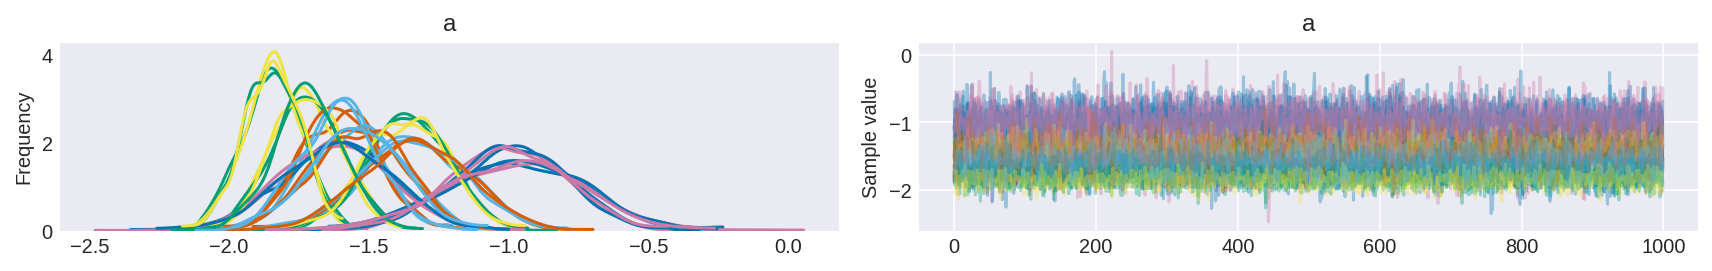

In [113]:
pm.traceplot(trace_10_3);

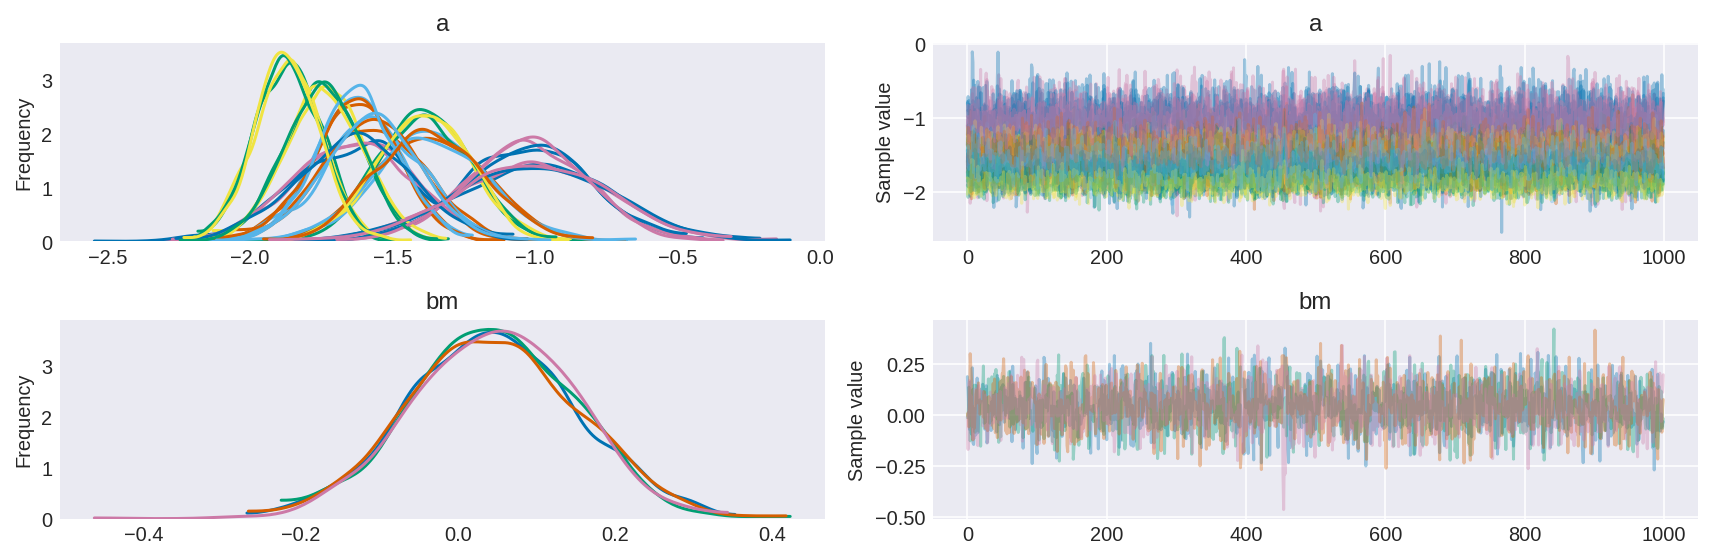

In [114]:
pm.traceplot(trace_10_4);

In [112]:

comp_df = pm.compare({model_10_1 : trace_10_1,
                      model_10_2 : trace_10_2,
                      model_10_3 : trace_10_3,
                      model_10_4 : trace_10_4},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m10.1', 'm10.2', 'm10.3', 'm10.4'])
comp_df = comp_df.set_index('model')
comp_df

/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/brian/anaconda2/envs/py36/lib/python3.6/site-pack

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m10.3,128.22,11.93,0,0.47,9.48,0,1
m10.1,129.8,4.78,1.58,0.21,8.64,9.49,1
m10.2,130.31,2.79,2.09,0.16,12.95,11.61,1
m10.4,130.39,13.31,2.17,0.16,9.3,0.97,1


Interesting. The model wiht just department and just male have the best predicted out of sample accuracy. Does this mean including both leads to overfitting--learning the noise in stead of the signal?

In [146]:
pm.summary(trace_10_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,-1.03,0.21,0.0,-1.38,-0.70,5631.92,1.0
a__1,-1.40,0.16,0.0,-1.65,-1.14,4526.61,1.0
a__2,-1.63,0.15,0.0,-1.87,-1.40,4868.73,1.0
a__3,-1.64,0.21,0.0,-1.97,-1.30,5478.84,1.0
a__4,-1.75,0.13,0.0,-1.96,-1.53,4678.28,1.0
a__5,-1.37,0.20,0.0,-1.66,-1.05,4429.36,1.0
a__6,-1.01,0.27,0.0,-1.44,-0.58,5093.15,1.0
a__7,-1.87,0.11,0.0,-2.05,-1.68,4502.40,1.0
a__8,-1.57,0.17,0.0,-1.87,-1.31,4261.79,1.0
bm,0.04,0.10,0.0,-0.11,0.22,3180.08,1.0


In [189]:
np.exp(.04)

1.0408107741923882

In [191]:
post = pm.trace_to_dataframe(trace_10_4)
# take mean along rows
a = post.loc[:, post.columns.str.startswith('a')].mean(axis=1)
# create new axis so lined up with b
a = a[:,np.newaxis]
b = post.loc[:, post.columns.str.startswith('b')].values
# transform
p_admit_male = p_from_log_odds(a + b)
p_admit_female = p_from_log_odds(a)
diff_admit = p_admit_male - p_admit_female
# make df
diff_admit = pd.DataFrame(diff_admit)
diff_admit.describe(percentiles=[.025, .5, .975])

,0
count,4000.000000
mean,0.006445
std,0.016047
min,-0.074599
2.5%,-0.025020
50%,0.006567
97.5%,0.037279
max,0.065518


What is your causal interpretation? if NWO's goal is to equalize rates of funding between the genders, what type of intervention would be most effective? -McElreath

We expect a probability increase of .006 by being male now. Thus, by taking into account discipline, we turn a 3% increase in probability into a .6% increase in probability. This is because women tend to apply to the more competetive disciplines with lower acceptance rates, so by taking this information into account it stratifies the model to this.  This model shows no obvious discrimination in the awards given based on gender. However, the situation is much more complex in real life, McElreath suggests it would be hasty to conclude there are no other influences.  

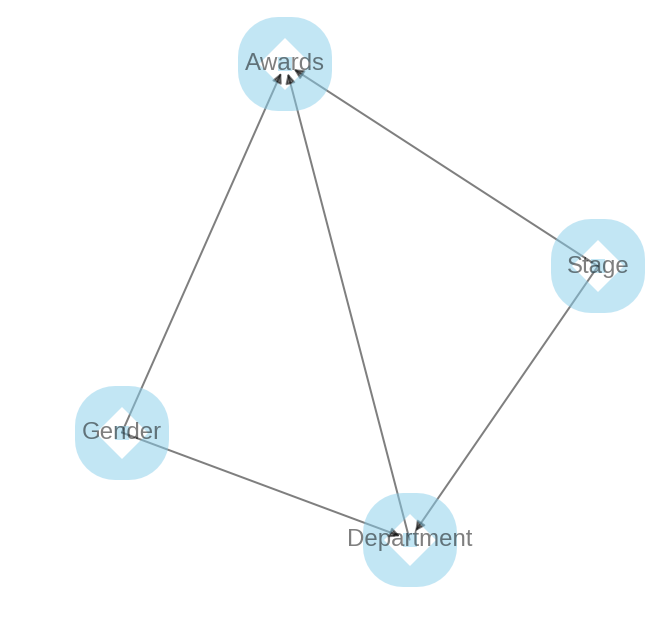

In [184]:
# What if Stage of career influences both who gets awards and that some disciplines 
# apply when young and others when older, so stage affects what disciplines apply

######
# DAG
######

plt.figure(figsize=(4,4))
G = nx.DiGraph()
rvs = ['Gender', 'Department','Awards', 'Stage']

G.add_nodes_from(rvs)
G.add_edges_from([('Gender','Department'),('Department','Awards'),('Gender','Awards'), 
                 ('Stage','Awards'),('Stage','Department')], weight=1)
#nx.draw_networkx(G, arrows=True)
nx.draw(G, with_labels=True, node_size=50, node_color="skyblue", fontsize = 100, fontweight = 'bold',node_shape="s", alpha=0.5, linewidths=40)
plt.show()

If this structure is accurate, we have turned Department into a collider. In which conditioning on it opens a backdoor path, whereby information can flow from Department to stage and then affect Awards. Therefore, our 10_4 model is capturing total effects in the department to awards parameter, and interpreting it as soley Departments causal effects on Awards is not accurate.